<a href="https://colab.research.google.com/github/pranshurastogi29/clustering-the-palsy/blob/master/PSO_and_HPSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score

In [0]:
import numpy as np
from scipy.spatial.distance import cdist
class KMeans:

    def __init__(
            self,
            n_cluster: int,
            init_pp: bool = True,
            max_iter: int = 300,
            tolerance: float = 1e-4,
            seed: int = None):
        
        self.n_cluster = n_cluster
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.init_pp = init_pp
        self.seed = seed
        self.centroid = None
        self.mse = None

    def fit(self, data: np.ndarray):
        
        self.centroid = self._init_centroid(data)
        for _ in range(self.max_iter):
            distance = self._calc_distance(data)
            cluster = self._assign_cluster(distance)
            new_centroid = self._update_centroid(data, cluster)
            diff = np.abs(self.centroid - new_centroid).mean()
            self.centroid = new_centroid

            if diff <= self.tolerance:
                break

        self.mse = calc_mse(self.centroid, cluster, data)

    def predict(self, data: np.ndarray):

        distance = self._calc_distance(data)
        cluster = self._assign_cluster(distance)
        return cluster

    def _init_centroid(self, data: np.ndarray):
        
        if self.init_pp:
            np.random.seed(self.seed)
            centroid = [int(np.random.uniform()*len(data))]
            for _ in range(1, self.n_cluster):
                dist = []
                dist = [min([np.inner(data[c]-x, data[c]-x) for c in centroid])
                        for i, x in enumerate(data)]
                dist = np.array(dist)
                dist = dist / dist.sum()
                cumdist = np.cumsum(dist)

                prob = np.random.rand()
                for i, c in enumerate(cumdist):
                    if prob > c and i not in centroid:
                        centroid.append(i)
                        break
            centroid = np.array([data[c] for c in centroid])
        else:
            np.random.seed(self.seed)
            idx = np.random.choice(range(len(data)), size=(self.n_cluster))
            centroid = data[idx]
        return centroid

    def _calc_distance(self, data: np.ndarray):
        """distances = []
        for c in self.centroid:
            distance = np.mean((data - c) * (data - c), axis=1)
            distances.append(distance)
        distances = np.array(distances)
        distances = distances.T"""
        distances = cdist(data,self.centroid)
        return distances

    def _assign_cluster(self, distance: np.ndarray):
        cluster = np.argmin(distance, axis=1)
        return cluster

    def _update_centroid(self, data: np.ndarray, cluster: np.ndarray):
        centroids = []
        for i in range(self.n_cluster):
            idx = np.where(cluster == i)
            centroid = np.mean(data[idx], axis=0)
            centroids.append(centroid)
        centroids = np.array(centroids)
        return centroids


In [0]:
import numpy as np
from scipy.linalg import norm
from scipy.spatial.distance import cdist

class FCM:
    
    def __init__(self, n_clusters=10, max_iter=150, m=2, error=1e-5, random_state=0):
        assert m > 1
        self.u, self.centers = None, None
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.error = error
        self.random_state = random_state

    def fit(self, X):
        
        self.n_samples = X.shape[0]
        r = np.random.RandomState(self.random_state)
        u = r.rand(self.n_samples, self.n_clusters)
        u = u / np.tile(u.sum(axis=1)[np.newaxis].T, self.n_clusters)

        r = np.random.RandomState(self.random_state)
        self.u = r.rand(self.n_samples,self.n_clusters)
        self.u = self.u / np.tile(self.u.sum(axis=1)[np.newaxis].T, self.n_clusters)

        for iteration in range(self.max_iter):
            u_old = self.u.copy()

            self.centers = self.next_centers(X)
            self.u = self._predict(X)

            if norm(self.u - u_old) < self.error:
                break


    def next_centers(self, X):
        
        um = self.u ** self.m
        return (X.T @ um / np.sum(um, axis=0)).T

    def _predict(self, X):
        
        power = float(2 / (self.m - 1))
        temp = cdist(X, self.centers) ** power
        denominator_ = temp.reshape((X.shape[0], 1, -1)).repeat(temp.shape[-1], axis=1)
        denominator_ = temp[:, :, np.newaxis] / denominator_

        return 1 / denominator_.sum(2)

    def predict(self, X):

        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)

        u = self._predict(X)
        return np.argmax(u, axis=-1)

In [0]:
def quantization_error(centroids: np.ndarray, labels: np.ndarray, data: np.ndarray) -> float:
    error = 0.0
    for i, c in enumerate(centroids):
        idx = np.where(labels == i)
        dist = np.linalg.norm(data[idx] - c)
        dist /= len(idx)
        error += dist
    error /= len(centroids)
    return error

def calc_mse(centroids: np.ndarray, labels: np.ndarray, data: np.ndarray):
    distances = []
    for i, c in enumerate(centroids):
        idx = np.where(labels == i)
        dist = np.mean((data[idx] - c)**2)
        distances.append(dist)
    return np.mean(distances)


class Particle:

    def __init__(self,
                 n_cluster: int,
                 data: np.ndarray,
                 use_kmeans: bool = False,
                 w: float = 0.9,
                 c1: float = 0.5,
                 c2: float = 0.3):
        index = np.random.choice(list(range(len(data))), n_cluster)
        self.centroids = data[index].copy()
        if use_kmeans:
            kmeans = KMeans(n_cluster=n_cluster, init_pp=False)
            kmeans.fit(data)
            self.centroids = kmeans.centroid.copy()
        self.best_position = self.centroids.copy()
        self.best_score = quantization_error(self.centroids, self._predict(data), data)
        self.best_mse = calc_mse(self.centroids, self._predict(data), data)
        self.velocity = np.zeros_like(self.centroids)
        self._w = w
        self._c1 = c1
        self._c2 = c2

    def update(self, gbest_position: np.ndarray, data: np.ndarray):

        self._update_velocity(gbest_position)
        self._update_centroids(data)

    def _update_velocity(self, gbest_position: np.ndarray):
        """Update velocity based on old value, cognitive component, and social component
        """

        v_old = self._w * self.velocity
        cognitive_component = self._c1 * np.random.random() * (self.best_position - self.centroids)
        social_component = self._c2 * np.random.random() * (gbest_position - self.centroids)
        self.velocity = v_old + cognitive_component + social_component

    def _update_centroids(self, data: np.ndarray):
        self.centroids = self.centroids + self.velocity
        new_score = quantization_error(self.centroids, self._predict(data), data)
        mse = calc_mse(self.centroids, self._predict(data), data)
        self.best_mse = min(mse, self.best_mse)
        if new_score < self.best_score:
            self.best_score = new_score
            self.best_position = self.centroids.copy()

    def _predict(self, data: np.ndarray) -> np.ndarray:
        """Predict new data's cluster using minimum distance to centroid
        """
        distance = self._calc_distance(data)
        cluster = self._assign_cluster(distance)
        return cluster

    def _calc_distance(self, data: np.ndarray) -> np.ndarray:
        """distances = []
        for c in self.centroid:
            distance = np.mean((data - c) * (data - c), axis=1)
            distances.append(distance)

        distances = np.array(distances)
        distances = distances.T"""
        distances = cdist(data,self.centroids)
        return distances

    def _assign_cluster(self, distance: np.ndarray) -> np.ndarray:
        """Assign cluster to data based on minimum distance to centroids
        """
        cluster = np.argmin(distance, axis=1)
        return cluster


In [0]:
class ParticleSwarmOptimizedClustering:
    def __init__(self,
                 n_cluster: int,
                 n_particles: int,
                 data: np.ndarray,
                 hybrid: bool = True,
                 max_iter: int = 100,
                 print_debug: int = 10):
        self.n_cluster = n_cluster
        self.n_particles = n_particles
        self.data = data
        self.max_iter = max_iter
        self.particles = []
        self.hybrid = hybrid

        self.print_debug = print_debug
        self.gbest_score = np.inf
        self.gbest_centroids = None
        self.gbest_mse = np.inf
        self._init_particles()

    def _init_particles(self):
        for i in range(self.n_particles):
            particle = None
            if i == 0 and self.hybrid:
                particle = Particle(self.n_cluster, self.data, use_kmeans=True)
            else:
                particle = Particle(self.n_cluster, self.data, use_kmeans=False)
            if particle.best_score < self.gbest_score:
                self.gbest_centroids = particle.centroids.copy()
                self.gbest_score = particle.best_score
            self.particles.append(particle)
            self.gbest_mse = min(particle.best_mse, self.gbest_mse)

    def run(self):
        print('Initial global best score', self.gbest_score)
        history = []
        for i in range(self.max_iter):
            for particle in self.particles:
                particle.update(self.gbest_centroids, self.data)
                # print(i, particle.best_score, self.gbest_score)
            for particle in self.particles:
                if particle.best_score < self.gbest_score:
                    self.gbest_centroids = particle.centroids.copy()
                    self.gbest_score = particle.best_score
            history.append(self.gbest_score)
            if i % self.print_debug == 0:
                print('Iteration {:04d}/{:04d} current gbest score {:.18f}'.format(
                    i + 1, self.max_iter, self.gbest_score))
        print('Finish with gbest score {:.18f}'.format(self.gbest_score))
        return history
    
    def _calc_distance(self, data: np.ndarray):
        """distances = []
        for c in self.centroid:
            distance = np.mean((data - c) * (data - c), axis=1)
            distances.append(distance)

        distances = np.array(distances)
        distances = distances.T"""
        distances = cdist(data,self.centroid)
        return distances

    def predict(self, distance: np.ndarray):
        
        cluster = np.argmin(distance, axis=1)
        return cluster

In [0]:
from sklearn.metrics.pairwise import euclidean_distances

def delta(ck, cl):
    values = np.ones([len(ck), len(cl)])*10000
    
    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])
            
    return np.min(values)
    
def big_delta(ci):
    values = np.zeros([len(ci), len(ci)])
    
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
            
    return np.max(values)
    
def dunn(k_list):
    
    deltas = np.ones([len(k_list), len(k_list)])*1000000
    big_deltas = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta(k_list[k], k_list[l])
        
        big_deltas[k] = big_delta(k_list[k])

    di = 10*np.min(deltas)/np.max(big_deltas)
    return di

In [0]:
df=pd.read_csv('/content/drive/My Drive/norm.csv')

In [0]:
df_req = df[['Stride Length (m)', 'Cadence(steps/min)', 'Leg Length (m)',
       'Age(years)','classs']]
X  = df_req[['Stride Length (m)', 'Cadence(steps/min)', 'Leg Length (m)',
       'Age(years)']]
labels = df.classs.values

In [0]:
pso = ParticleSwarmOptimizedClustering(
        n_cluster=2, n_particles=50, data=X.values, max_iter=1000, print_debug=50,hybrid = False)

In [63]:
hist = pso.run()

Initial global best score 160.9299556490496
Iteration 0001/1000 current gbest score 159.167811998521472105
Iteration 0051/1000 current gbest score 156.204274357554623975
Iteration 0101/1000 current gbest score 156.201604918312057180
Iteration 0151/1000 current gbest score 156.201565352670343145
Iteration 0201/1000 current gbest score 156.201527155461207030
Iteration 0251/1000 current gbest score 156.201263765176889819
Iteration 0301/1000 current gbest score 156.201071212290912626
Iteration 0351/1000 current gbest score 156.200927976882695702
Iteration 0401/1000 current gbest score 156.200874655600671304
Iteration 0451/1000 current gbest score 156.200842989995322796
Iteration 0501/1000 current gbest score 156.200828922110588337
Iteration 0551/1000 current gbest score 156.200806961664824257
Iteration 0601/1000 current gbest score 156.200782772365670326
Iteration 0651/1000 current gbest score 156.200776535862360106
Iteration 0701/1000 current gbest score 156.200769425602800311
Iteration 0

In [64]:
pso.gbest_centroids

array([[  0.90560384, 139.73722172,   0.55611743,   7.63286423],
       [  0.80336939,  88.66418627,   0.68081735,  11.83911657]])

In [65]:
dunn(pso.gbest_centroids)

0.007345425945806525

In [66]:
pso.gbest_mse

90.2075939388121

In [0]:
c = pso.predict(X.values)

In [0]:
from sklearn.metrics.pairwise import euclidean_distances
def get_cls(c,x):
  cl0,cl1 = [],[]
  for i in range(len(c)):
    if c[i] == 0:
      cl0.append(x[i])
    if c[i] == 1:
      cl1.append(x[i])
  return cl0,cl1
def cluster_dist(cl0,cl1):
  d0 = euclidean_distances(cl0, cl1)
  d1 = euclidean_distances(cl1, cl0)
  A = euclidean_distances(cl0, cl0)
  C = euclidean_distances(cl1, cl1)
  d0 = np.sum(np.mean(d0,axis=1),axis=0)
  d1 = np.sum(np.mean(d1,axis=1),axis=0)
  a = np.sum(np.sum(A,axis=1)/(len(A)))/2
  c = np.sum(np.sum(C,axis=1)/(len(C)))/2
  return min([d0,d1]),(a+c)/2

In [0]:
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [70]:
purity_score(labels,c)

0.6153846153846154

In [71]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
from scipy import stats
kfold = StratifiedKFold(n_splits=16, random_state = 42)
pso_cpi = []
i = 0
X1 = X.values
for train_index, test_index in kfold.split(X1,labels):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    print('ITER :',i)
    pso_rep = ParticleSwarmOptimizedClustering(
        n_cluster=2, n_particles=100, data=X_train, hybrid=False, max_iter=200, print_debug=2000)
    pso_rep.run()
    pso_kmeans = KMeans(n_cluster=2, init_pp=False, seed=2018)
    pso_kmeans.centroid = pso_rep.gbest_centroids.copy()
    predicted_pso_rep = pso_kmeans.predict(X1)
    cl0,cl1 = get_cls(predicted_pso_rep,X1)
    inter_cluster,intra_cluster = cluster_dist(cl0,cl1)
    print("Silhouette Coefficient : %0.3f"
      % silhouette_score(X1,predicted_pso_rep, metric='euclidean'))
    print('mse : %0.3f' % calc_mse(centroids=pso_rep.gbest_centroids, data=X1, labels=predicted_pso_rep))
    print('purity : %0.3f' % purity_score(labels,predicted_pso_rep))
    print('dunn : %0.3f' % dunn(pso_rep.gbest_centroids))
    print('inter_cluster_distance =',inter_cluster,
    "The average intra_cluster ", intra_cluster)
    pso_cpi.append(purity_score(labels,predicted_pso_rep))
    i = i+1

ITER : 0
Initial global best score 156.21976198102078
Iteration 0001/0200 current gbest score 156.219761981020781150
Finish with gbest score 153.976191018620312434
Silhouette Coefficient : 0.575
mse : 85.889
purity : 0.654
dunn : 0.002
inter_cluster_distance = 1961.3982795267777 The average intra_cluster  792.2462600991225
ITER : 1
Initial global best score 155.64280613412447
Iteration 0001/0200 current gbest score 155.642806134124469963
Finish with gbest score 152.959119095623123030
Silhouette Coefficient : 0.575
mse : 85.809
purity : 0.654
dunn : 0.004
inter_cluster_distance = 1961.3982795267777 The average intra_cluster  792.2462600991225
ITER : 2
Initial global best score 138.15026011752275
Iteration 0001/0200 current gbest score 138.150260117522748260
Finish with gbest score 136.765358836585789959
Silhouette Coefficient : 0.575
mse : 86.100
purity : 0.654
dunn : 0.001
inter_cluster_distance = 1961.3982795267777 The average intra_cluster  792.2462600991225
ITER : 3
Initial global b

In [72]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
from scipy import stats
kfold = StratifiedKFold(n_splits=16, random_state = 42)
hpso_km_cpi = []
#X = X.values
i = 0
for train_index, test_index in kfold.split(X1,labels):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    print('ITER :',i)
    pso_rep = ParticleSwarmOptimizedClustering(
        n_cluster=2, n_particles=70, data=X_train, hybrid=True, max_iter=200, print_debug=2000)
    pso_rep.run()
    pso_kmeans = KMeans(n_cluster=2, init_pp=False, seed=2018)
    pso_kmeans.centroid = pso_rep.gbest_centroids.copy()
    predicted_pso_rep = pso_kmeans.predict(X1)
    cl0,cl1 = get_cls(predicted_pso_rep,X1)
    inter_cluster,intra_cluster = cluster_dist(cl0,cl1)
    print("Silhouette Coefficient : %0.3f"
      % silhouette_score(X1,predicted_pso_rep, metric='euclidean'))
    print('mse : %0.3f' % calc_mse(centroids=pso_rep.gbest_centroids, data=X1, labels=predicted_pso_rep))
    print('purity : %0.3f' % purity_score(labels,predicted_pso_rep))
    print('dunn : %0.3f' % dunn(pso_rep.gbest_centroids))
    print('inter_cluster_distance =',inter_cluster,
    "The average intra_cluster :", intra_cluster)
    hpso_km_cpi.append(purity_score(labels,predicted_pso_rep))
    i = i+1

ITER : 0
Initial global best score 159.42739350903935
Iteration 0001/0200 current gbest score 159.427393509039347919
Finish with gbest score 153.975643960135926136
Silhouette Coefficient : 0.575
mse : 85.888
purity : 0.654
dunn : 0.009
inter_cluster_distance = 1961.3982795267777 The average intra_cluster : 792.2462600991225
ITER : 1
Initial global best score 154.06717818046363
Iteration 0001/0200 current gbest score 153.874932389017374135
Finish with gbest score 152.957663839892745727
Silhouette Coefficient : 0.575
mse : 85.804
purity : 0.654
dunn : 0.009
inter_cluster_distance = 1961.3982795267777 The average intra_cluster : 792.2462600991225
ITER : 2
Initial global best score 140.25990169033065
Iteration 0001/0200 current gbest score 140.259901690330650581
Finish with gbest score 136.700560185830340743
Silhouette Coefficient : 0.575
mse : 86.073
purity : 0.654
dunn : 0.001
inter_cluster_distance = 1961.3982795267777 The average intra_cluster : 792.2462600991225
ITER : 3
Initial globa

In [73]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
from scipy import stats
kfold = StratifiedKFold(n_splits=16, random_state = 42)
hpso_fm_cpi = []
#X = X.values
i = 0
for train_index, test_index in kfold.split(X1,labels):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    print('ITER :',i)
    pso_rep = ParticleSwarmOptimizedClustering(
        n_cluster=2, n_particles=120, data=X_train, hybrid=True, max_iter=200, print_debug=2000)
    pso_rep.run()
    pso_fcm = FCM(n_clusters=2)
    pso_fcm.centers = pso_rep.gbest_centroids.copy()
    predicted_pso_rep = pso_fcm.predict(X1)
    cl0,cl1 = get_cls(predicted_pso_rep,X1)
    inter_cluster,intra_cluster = cluster_dist(cl0,cl1)
    print("Silhouette Coefficient : %0.3f"
      % silhouette_score(X1,predicted_pso_rep, metric='euclidean'))
    print('mse : %0.3f' % calc_mse(centroids=pso_rep.gbest_centroids, data=X1, labels=predicted_pso_rep))
    print('purity : %0.3f' % purity_score(labels,predicted_pso_rep))
    print('dunn : %0.3f' % dunn(pso_rep.gbest_centroids))
    print('inter_cluster_distance =',inter_cluster,
    "The average intra_cluster ", intra_cluster)
    hpso_fm_cpi.append(purity_score(labels,predicted_pso_rep))
    i = i+1

ITER : 0
Initial global best score 154.80991288837137
Iteration 0001/0200 current gbest score 154.809912888371371764
Finish with gbest score 153.977697345740864421
Silhouette Coefficient : 0.575
mse : 85.893
purity : 0.654
dunn : 0.006
inter_cluster_distance = 1961.3982795267777 The average intra_cluster  792.2462600991225
ITER : 1
Initial global best score 155.56269827087695
Iteration 0001/0200 current gbest score 155.562698270876950346
Finish with gbest score 152.957782863018934449
Silhouette Coefficient : 0.575
mse : 85.804
purity : 0.654
dunn : 0.006
inter_cluster_distance = 1961.3982795267777 The average intra_cluster  792.2462600991225
ITER : 2
Initial global best score 138.5427560177823
Iteration 0001/0200 current gbest score 138.542756017782295430
Finish with gbest score 136.693145647518008445
Silhouette Coefficient : 0.575
mse : 86.069
purity : 0.654
dunn : 0.008
inter_cluster_distance = 1961.3982795267777 The average intra_cluster  792.2462600991225
ITER : 3
Initial global be

Automatically created module for IPython interactive environment
Initial global best score 161.7529444882702
Iteration 0001/0200 current gbest score 161.752944488270202328
Finish with gbest score 156.218455043418657624
For n_clusters = 2 The average silhouette_score is : 0.5745928624139238
Initial global best score 94.3586008918539
Iteration 0001/0200 current gbest score 94.358600891853896542
Finish with gbest score 93.520017990816015185
For n_clusters = 3 The average silhouette_score is : 0.5100797282537471
Initial global best score 67.5390422935736
Iteration 0001/0200 current gbest score 67.539042293573601228
Finish with gbest score 67.032912961791197404
For n_clusters = 4 The average silhouette_score is : 0.4716650174292413
Initial global best score 53.09137928849181
Iteration 0001/0200 current gbest score 53.091379288491808097
Finish with gbest score 52.130703302726828952
For n_clusters = 5 The average silhouette_score is : 0.43667769369334747
Initial global best score 40.479166904

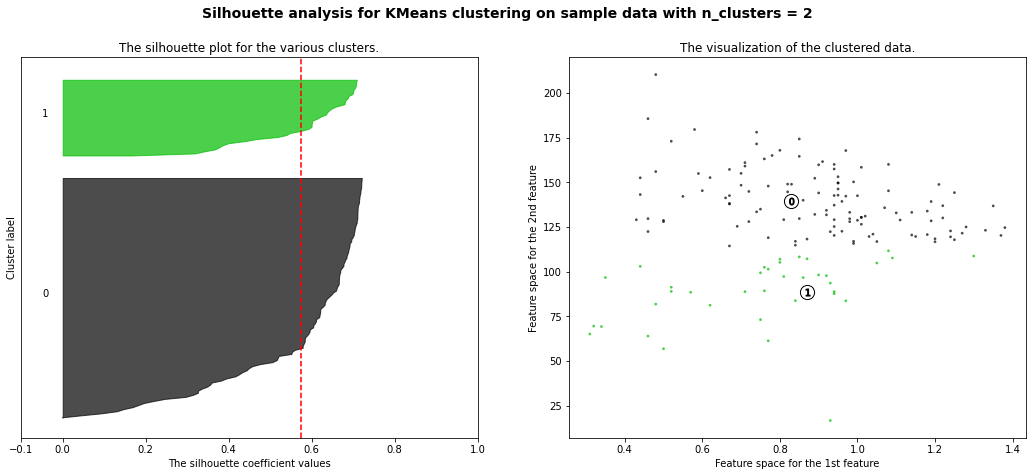

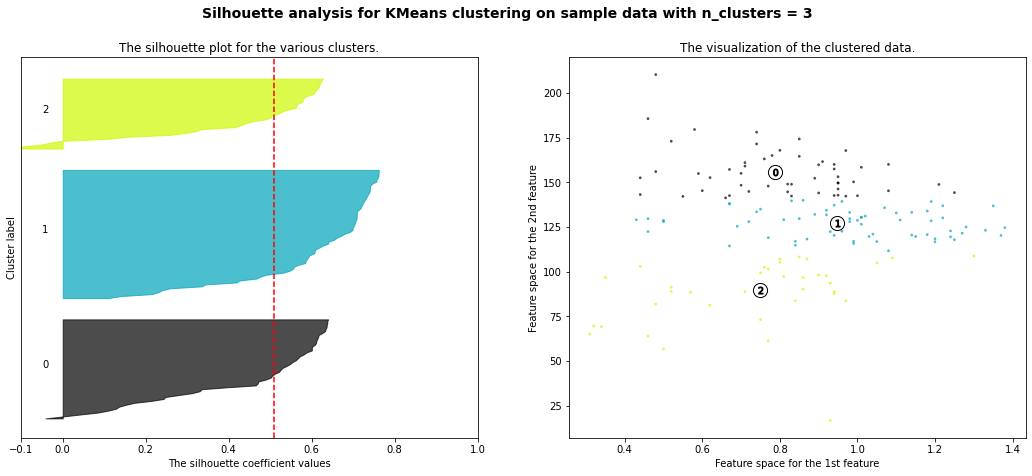

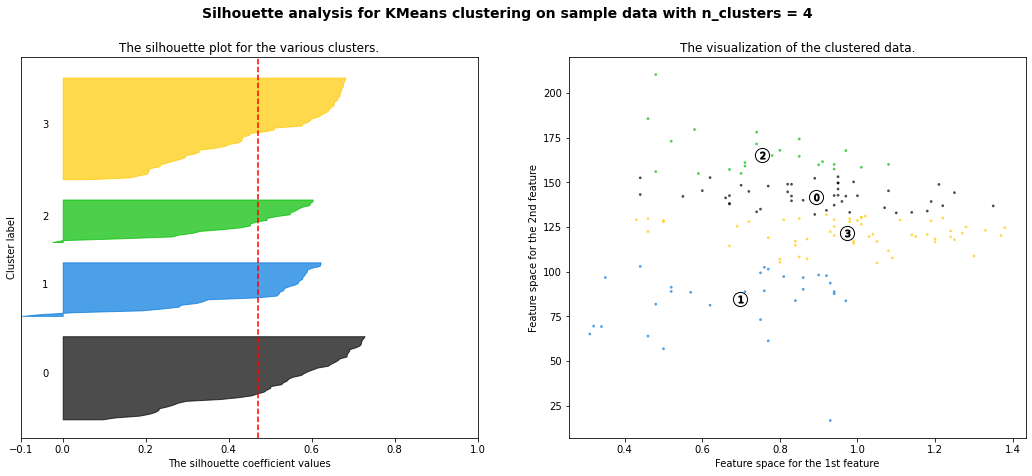

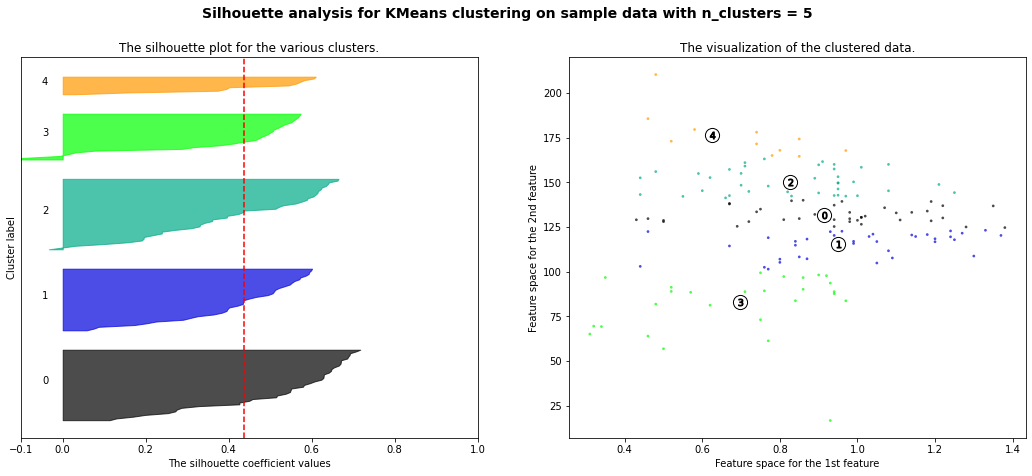

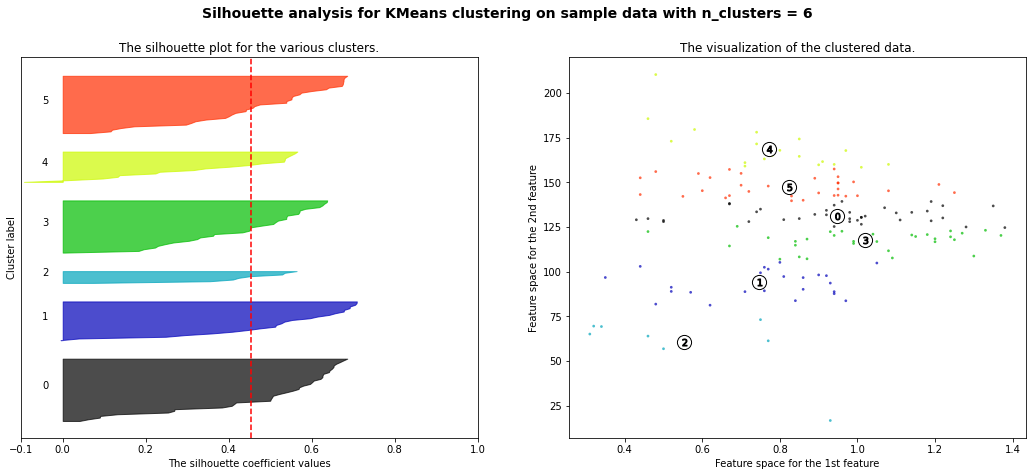

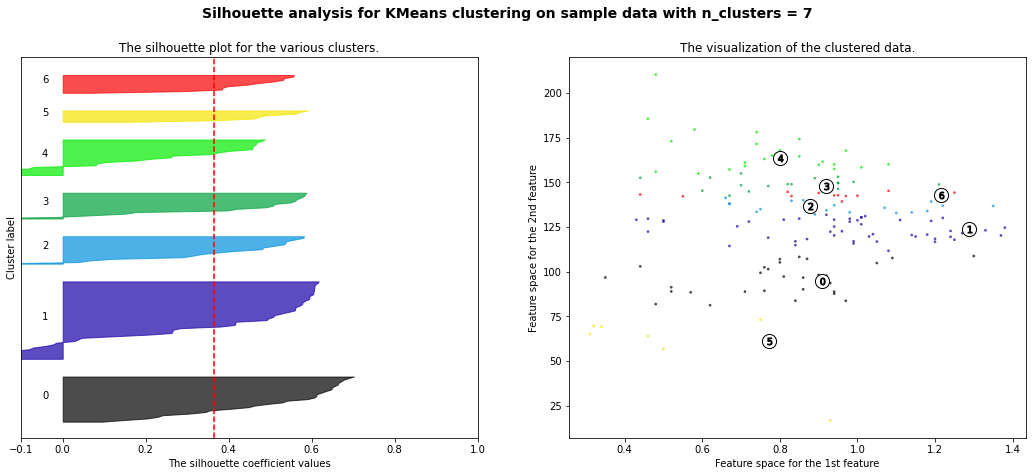

In [74]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.cm as cm
import matplotlib.pyplot as plt
print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
silhouette = []
range_n_clusters = [2, 3, 4, 5, 6,7]
X  = df_req[['Stride Length (m)', 'Cadence(steps/min)', 'Leg Length (m)',
       'Age(years)']].values
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = ParticleSwarmOptimizedClustering(
        n_cluster=n_clusters, n_particles=10, data=X, hybrid=True, max_iter=200, print_debug=2000)
    clusterer.run()
    pso_kmeans = KMeans(n_cluster=n_clusters, init_pp=False, seed=2018)
    pso_kmeans.centroid = clusterer.gbest_centroids.copy()
    cluster_labels = pso_kmeans.predict(X)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = pso_kmeans.centroid
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [75]:
import plotly.graph_objects as go

x = range_n_clusters

fig = go.Figure(data=go.Scatter(x=x, y=silhouette))
fig.show()